# Ocena jakości wina Vinho Verde

Celem zadania jest ocena jakości wina.

Uwzględniono dwa zbiory danych dotyczące próbek czerwonego wina Vinho Verde z północy Portugalii.

Źródło: 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

- 1600 obserwacji z 11 zmiennymi wejściowymi i jedną zmienną wyjściową.
- Zmienne opisują:
  1. Stałą kwasowość.
  2. Kwasowość lotną.
  3. Kwas cytrynowy.
  4. Cukier resztkowy.
  5. Chlorki.
  6. Wolny dwutlenek siarki.
  7. Całkowity dwutlenek siarki.
  8. Gęstość.
  9. pH.
  10. Siarczany.
  11. Alkohol.
  12. Jakość (ocena od 0 do 10).

[Dane](https://github.com/UEPP40/PUM/blob/c1ab27e52bc82cc151bb217b27bd25dfd057d9e8/winequality-red.csv)


# Import bibliotek, pliku csv oraz wstępny przegląd danych

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib as hl
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [2]:
# Wczytanie danych z pliku CSV do ramki danych
wineDataFrame = pd.read_csv('winequality-red.csv', sep=";")

# Wyświetlenie pierwszych 5 rekordów wraz z podstawowymi informacjami o danych
print("Pierwsze 5 rekordów zbioru danych:")
print(wineDataFrame.head(5))

print("\nInformacje o zbiorze danych:")
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

print("\nStatystyki opisowe zbioru danych:")
# Wyświetlenie statystyk opisowych zbioru danych
print(wineDataFrame.describe())

Pierwsze 5 rekordów zbioru danych:
   fixed acidity  volatile acidity citric acid residual sugar chlorides  \
0            7.4              0.70           0            1.9     0.076   
1            7.8              0.88           0            2.6     0.098   
2            7.8              0.76        0.04            2.3     0.092   
3           11.2              0.28        0.56            1.9     0.075   
4            7.4              0.70           0            1.9     0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2  

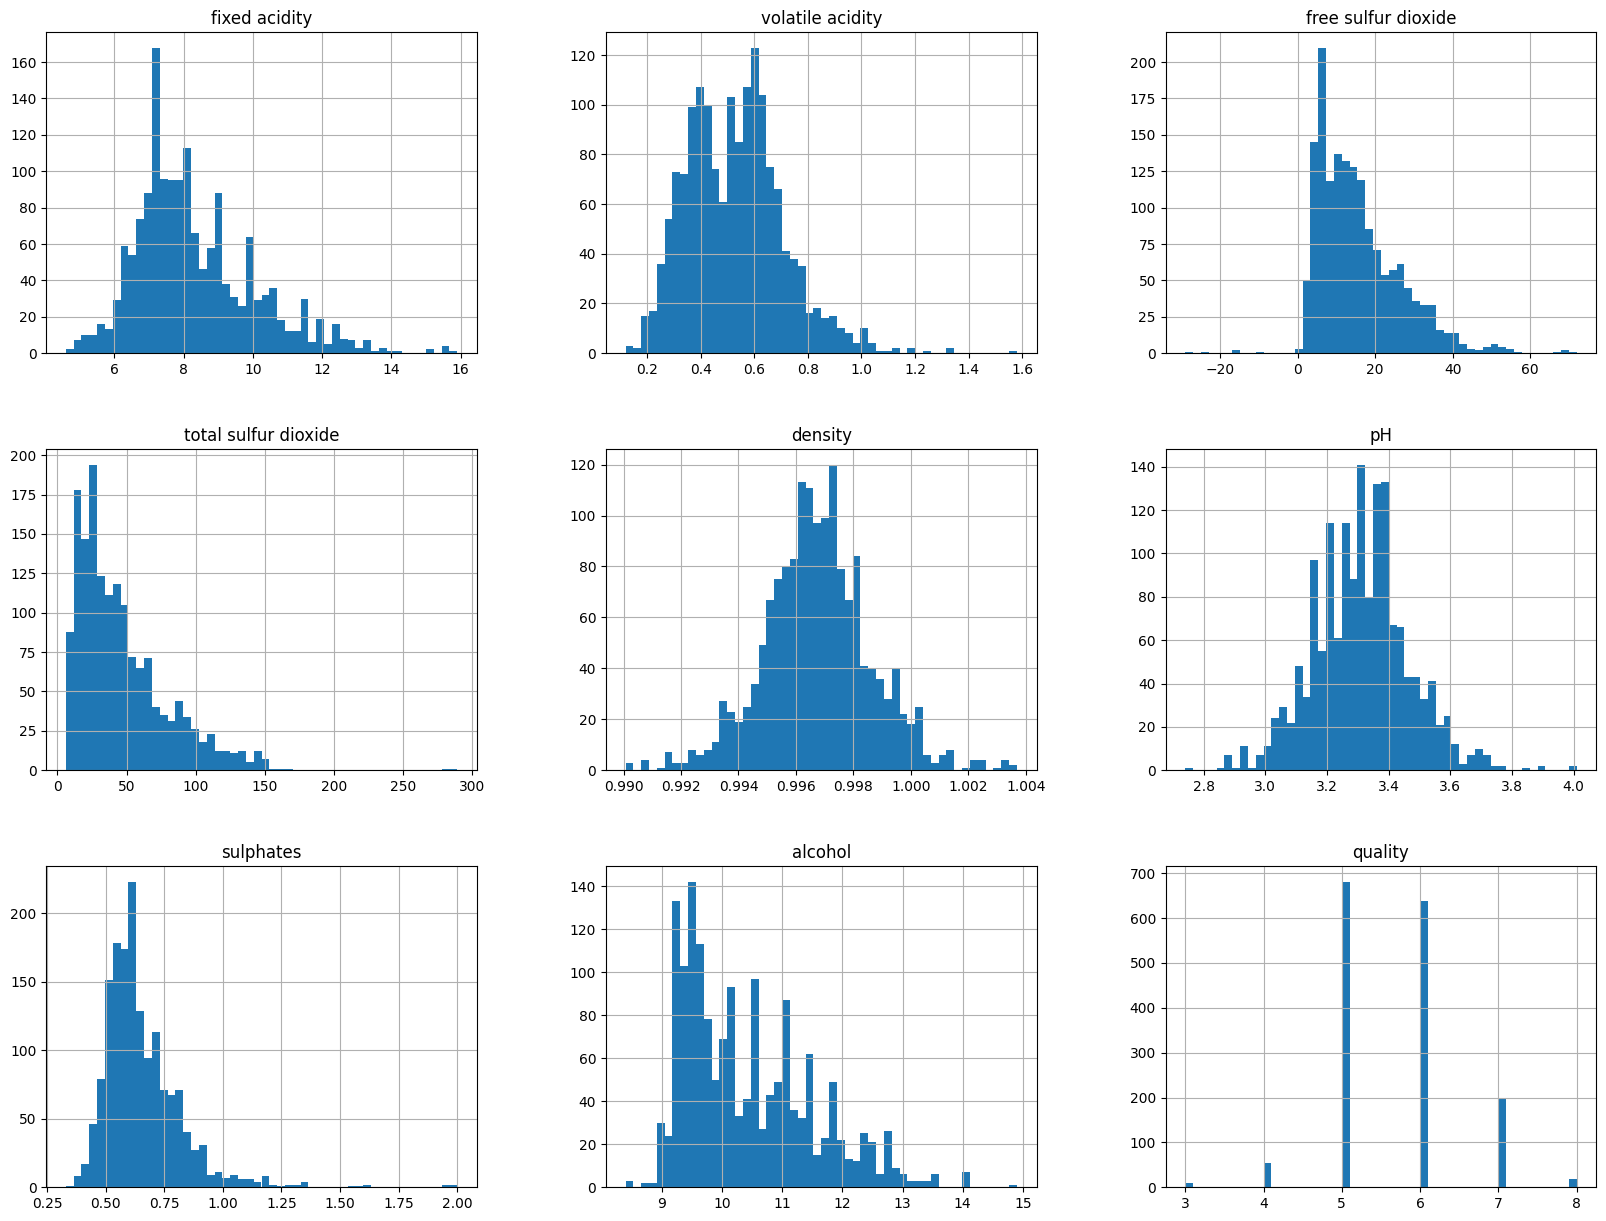

In [3]:
# Narysowanie histogramów dla wszystkich zmiennych oraz kilku innych przydatnych wykresów
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

# Czyszczenie danych

In [4]:
# Usuń zbędne znaki (nie będące Ascii)
for column in wineDataFrame.columns:
    wineDataFrame[column] = wineDataFrame[column].astype(str).str.replace(r'[^\x00-\x7F]+', '', regex=True)

# Zmien typ zmiennych ilościowych
for column in wineDataFrame.columns:
    wineDataFrame[column] = pd.to_numeric(wineDataFrame[column], errors='coerce')

# Usuń wszystkie wartości ujemne
wineDataFrame = wineDataFrame.mask(wineDataFrame < 0).dropna()

# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1583 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1583 non-null   float64
 1   volatile acidity      1583 non-null   float64
 2   citric acid           1583 non-null   float64
 3   residual sugar        1583 non-null   float64
 4   chlorides             1583 non-null   float64
 5   free sulfur dioxide   1583 non-null   float64
 6   total sulfur dioxide  1583 non-null   float64
 7   density               1583 non-null   float64
 8   pH                    1583 non-null   float64
 9   sulphates             1583 non-null   float64
 10  alcohol               1583 non-null   float64
 11  quality               1583 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 160.8 KB
None


In [5]:
# Usuń wiersze z duplikatami
# wineDataFrame.drop_duplicates(inplace=True)

# # zastąpienie psutych medianami
# wineDataFrame.fillna(wineDataFrame.median(), inplace=True)

# Remove rows with missing values
wineDataFrame.dropna(inplace=True)

# Display basic information about the data set
print(wineDataFrame.info())
print(wineDataFrame.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1583 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1583 non-null   float64
 1   volatile acidity      1583 non-null   float64
 2   citric acid           1583 non-null   float64
 3   residual sugar        1583 non-null   float64
 4   chlorides             1583 non-null   float64
 5   free sulfur dioxide   1583 non-null   float64
 6   total sulfur dioxide  1583 non-null   float64
 7   density               1583 non-null   float64
 8   pH                    1583 non-null   float64
 9   sulphates             1583 non-null   float64
 10  alcohol               1583 non-null   float64
 11  quality               1583 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 160.8 KB
None
(1583, 12)


In [6]:
# print empty values
print(wineDataFrame.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [7]:
# usunięcie rekorów z wartościami wyraźnie odstającymi
for column in wineDataFrame.columns:
    if column != 'quality' and pd.api.types.is_numeric_dtype(wineDataFrame[column]):
        Q1 = wineDataFrame[column].quantile(0.10)
        Q3 = wineDataFrame[column].quantile(0.90)
        IQR = Q3 - Q1

        filter = (wineDataFrame[column] >= Q1 - 1.5 * IQR) & (wineDataFrame[column] <= Q3 + 1.5 * IQR)
        wineDataFrame = wineDataFrame.loc[filter]

# Display basic information about the data set
print(wineDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1498 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1498 non-null   float64
 1   volatile acidity      1498 non-null   float64
 2   citric acid           1498 non-null   float64
 3   residual sugar        1498 non-null   float64
 4   chlorides             1498 non-null   float64
 5   free sulfur dioxide   1498 non-null   float64
 6   total sulfur dioxide  1498 non-null   float64
 7   density               1498 non-null   float64
 8   pH                    1498 non-null   float64
 9   sulphates             1498 non-null   float64
 10  alcohol               1498 non-null   float64
 11  quality               1498 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 152.1 KB
None


<class 'pandas.core.frame.DataFrame'>
Index: 1498 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1498 non-null   float64
 1   volatile acidity      1498 non-null   float64
 2   citric acid           1498 non-null   float64
 3   residual sugar        1498 non-null   float64
 4   chlorides             1498 non-null   float64
 5   free sulfur dioxide   1498 non-null   float64
 6   total sulfur dioxide  1498 non-null   float64
 7   density               1498 non-null   float64
 8   pH                    1498 non-null   float64
 9   sulphates             1498 non-null   float64
 10  alcohol               1498 non-null   float64
 11  quality               1498 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 152.1 KB
None


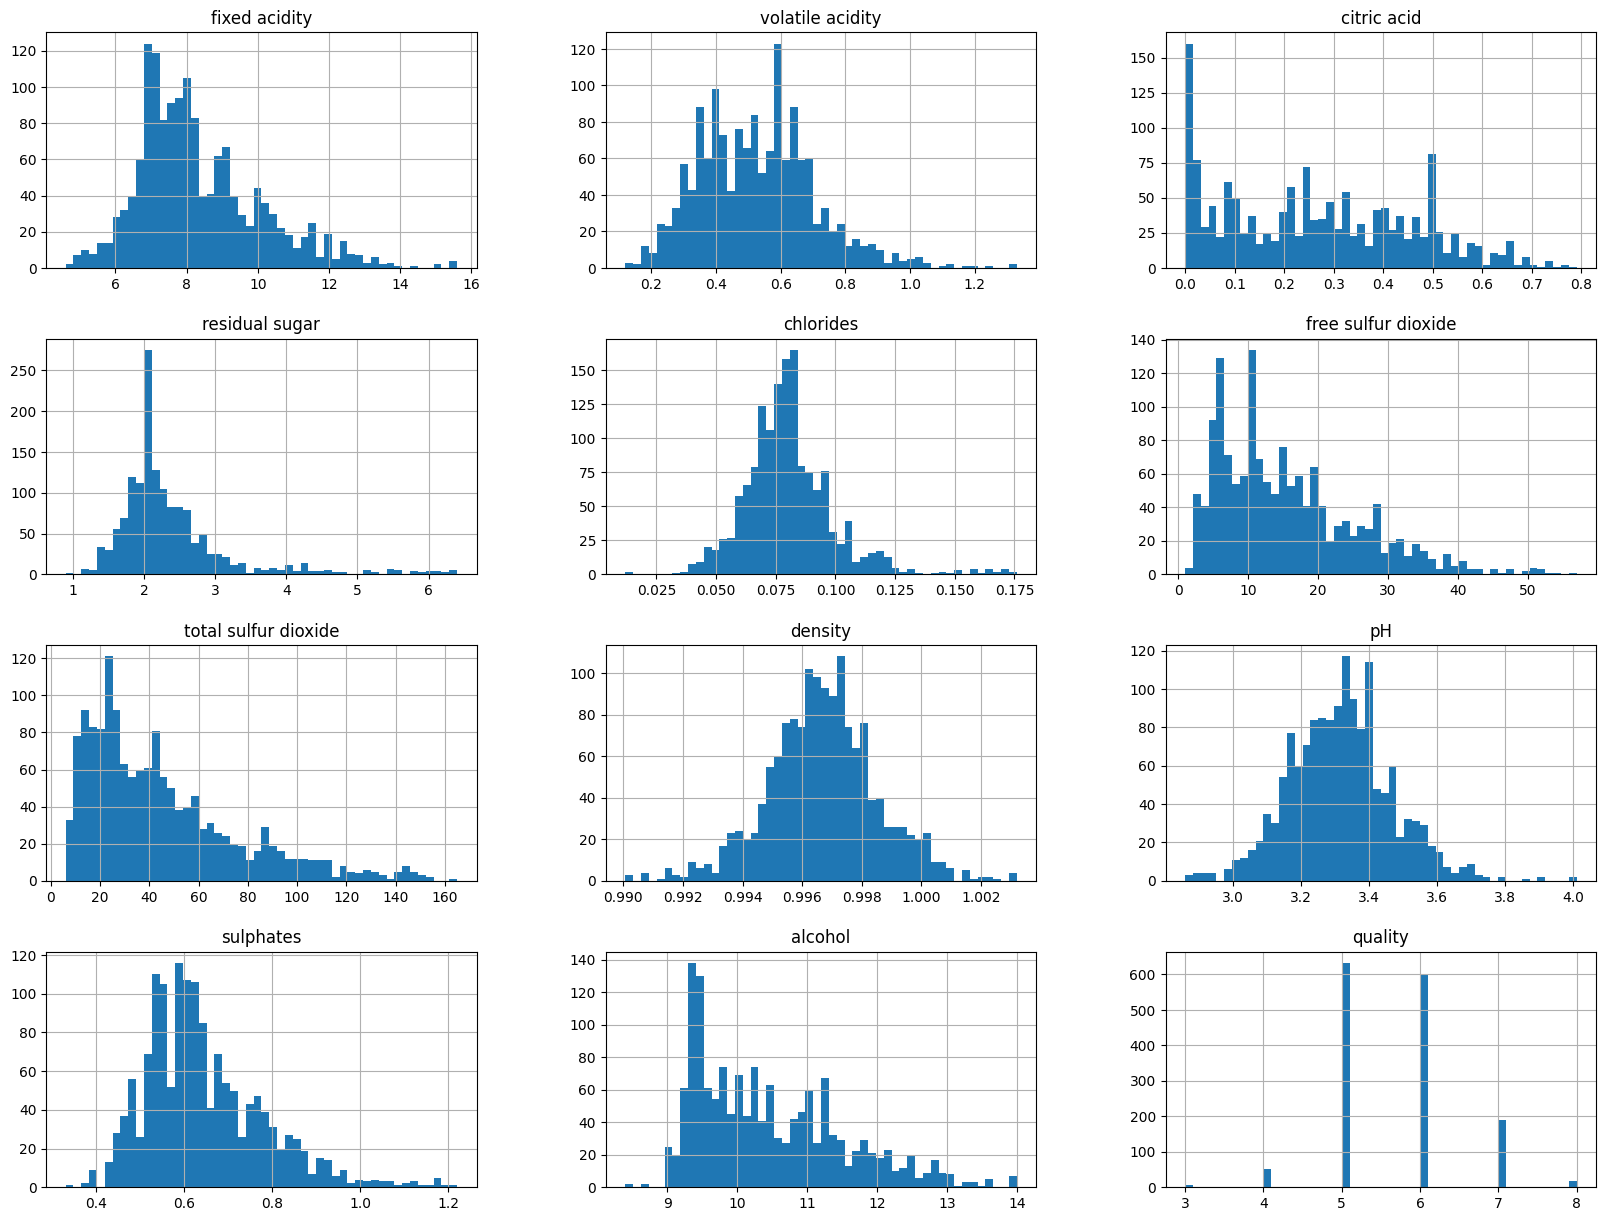

In [8]:
# Display basic information about the data set
print(wineDataFrame.info())
# plot histogram
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:

wineAllFeatures = wineDataFrame
wineAllFeatures.to_csv('wineAllFeatures.csv', index=False)
# # stwórz obiekt enkodera dla kolumn o typie obiektowym
# le = LabelEncoder()
# for column in wineDataFrame.columns:
#     if pd.api.types.is_object_dtype(wineDataFrame[column]):
#         wineDataFrame[column] = le.fit_transform(wineDataFrame[column])
# # sprawdź transformacje
# wineDataFrame.head()

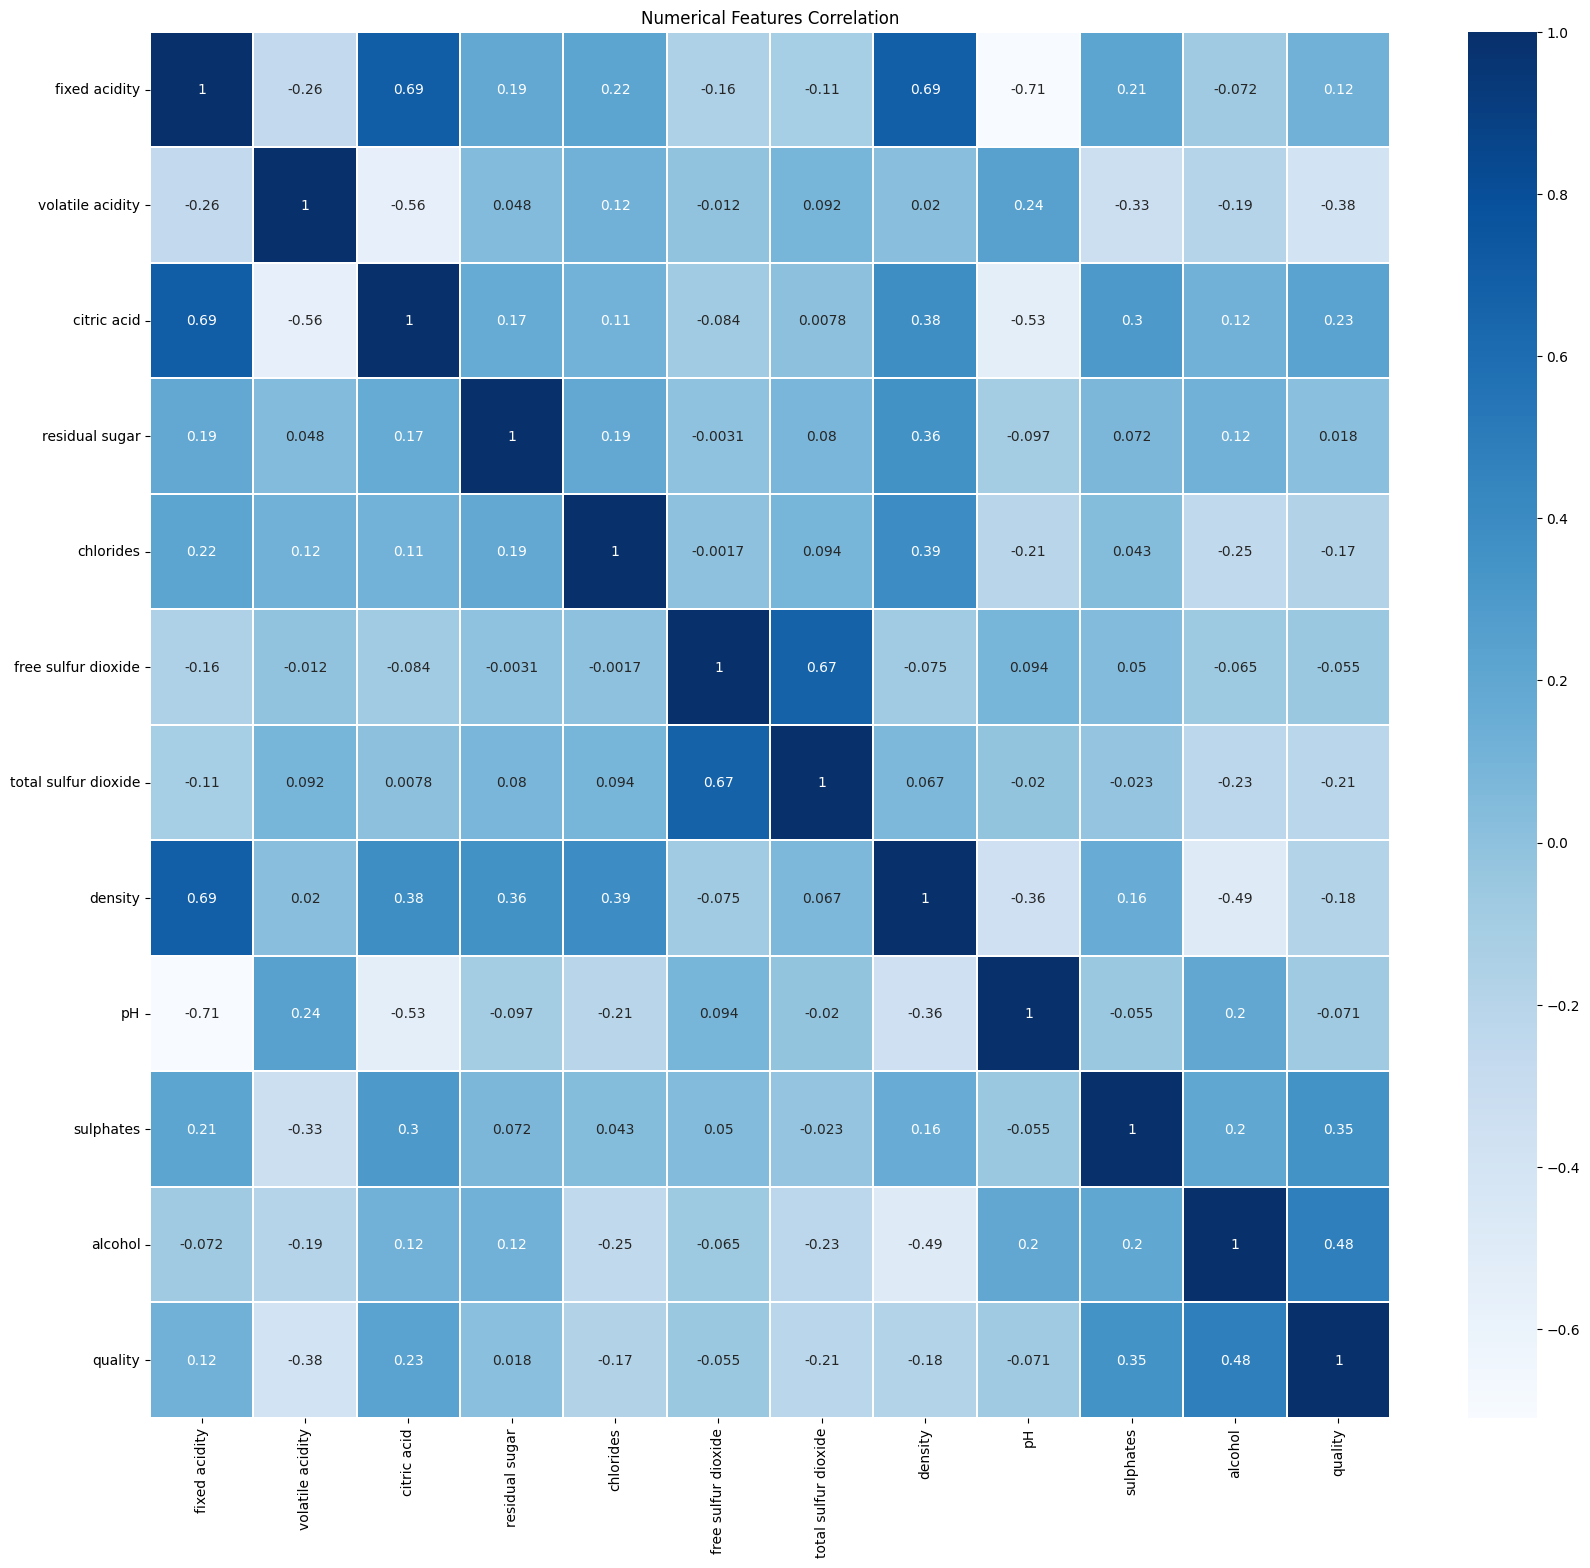

In [10]:
# wskaż korelacje
plt.figure(figsize = (20, 18)) 
# creating the correlation heatmap
sns.heatmap(wineDataFrame.corr(), annot = True, linewidths = 0.1, cmap = 'Blues')
plt.title('Numerical Features Correlation')
plt.show()

In [11]:
corr_matrix = wineDataFrame.corr()
cor_target = abs(corr_matrix["quality"])
relevant_features = cor_target[cor_target>0.20]

# print which features are relevant
print("Relevant features (correlation with 'quality' > 0.1):\n", relevant_features)

# and which are not
print("\nNon-relevant features (correlation with 'quality' <= 0.1):\n", cor_target[cor_target<=0.20])

wineDataFrame = wineDataFrame[relevant_features.index]

Relevant features (correlation with 'quality' > 0.1):
 volatile acidity        0.384261
citric acid             0.234773
total sulfur dioxide    0.209169
sulphates               0.351121
alcohol                 0.482090
quality                 1.000000
Name: quality, dtype: float64

Non-relevant features (correlation with 'quality' <= 0.1):
 fixed acidity          0.124972
residual sugar         0.018108
chlorides              0.174828
free sulfur dioxide    0.054790
density                0.181605
pH                     0.070867
Name: quality, dtype: float64


In [12]:
wineDataFrame.head(5)

,volatile acidity,citric acid,total sulfur dioxide,sulphates,alcohol,quality
0,0.70,0.00,34.0,0.56,9.4,5
1,0.88,0.00,67.0,0.68,9.8,5
2,0.76,0.04,54.0,0.65,9.8,5
3,0.28,0.56,60.0,0.58,9.8,6
4,0.70,0.00,34.0,0.56,9.4,5


In [13]:
wineData = wineDataFrame.drop(columns=["quality"])
wineRatings = wineDataFrame["quality"]
wineData.to_csv('wineData.csv', index=False)
wineRatings.to_csv('wineRatings.csv', index=False)

# Podział danych na zbiory treningowe i testowe (blokowanie walidacji krzyżowej do wywalenia)

In [14]:
# Podziel dane na zbiór uczący i testowy
X = wineDataFrame.drop(columns=["quality"])
y = wineDataFrame["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Rozmiar zbioru treningowego:", len(X_train))
print("Rozmiar zbioru testowego:", len(X_test))

Rozmiar zbioru treningowego: 1198
Rozmiar zbioru testowego: 300


In [15]:
# Display the data splits
print("Training data (features):")
print(X_train.head())
print("\nTest data (features):")
print(X_test.head())
print("\nTraining data (target):")
print(y_train.head())
print("\nTest data (target):")
print(y_test.head())

Training data (features):
      volatile acidity  citric acid  total sulfur dioxide  sulphates  alcohol
1238              0.73         0.00                  24.0       0.46      9.6
1354              0.58         0.03                  28.0       0.52     10.0
1188              0.64         0.23                 119.0       0.70     10.9
474               0.28         0.51                  24.0       0.89      9.4
1154              0.58         0.00                  63.0       0.68     11.4

Test data (features):
      volatile acidity  citric acid  total sulfur dioxide  sulphates  alcohol
1107              0.30         0.41                  24.0       0.85     11.7
1390              0.49         0.00                  33.0       0.59     12.5
1526              0.47         0.08                  38.0       0.65      9.6
1586              0.31         0.41                  60.0       0.85     11.4
850               0.43         0.44                  22.0       0.55      9.5

Training data 

In [16]:
# Eksport przygotowanych danych do plików CSV
# Zbiór uczący
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
# Zbiór testowy
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
